In [1]:
# set the working directory to the root project directory to make sure that the relative paths work
import os
os.chdir("..")

In [2]:
import os
import sys
import random
import time
import numpy as np
import yaml
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# after submission, we found a bug in our code that caused unnecessary slowdown of our influence-augmented local simulators
# without affecting the planning performance or the global simulator. the results plotted below were generated
# by the code with the bug removed.

In [3]:
# utils

def plot_bar(results, algos, labels, xs, metric, width):
    for algo_i, algo in enumerate(algos):
        steps = [i+(algo_i-1)*width for i in range(len(xs))]
        plt.bar(steps, [results[x][algo]["mean_"+metric] for x in xs], width, yerr=[results[x][algo]["ste_"+metric] for x in xs], label=labels[algo_i])

def plot_curve(results, algos, labels, xs, metric):
    for algo_i, algo in enumerate(algos):
        plt.errorbar(xs, [results[x][algo]["mean_"+metric] for x in xs], yerr=[results[x][algo]["ste_"+metric] for x in xs], label=labels[algo_i])
    
def plot_dots(results, algos, labels, xs, metric):
    for algo_i, algo in enumerate(algos):
        plt.errorbar(xs, [results[x][algo]["mean_"+metric] for x in xs], fmt='x', yerr=[results[x][algo]["ste_"+metric] for x in xs], label=labels[algo_i])
        
def grab_data(xs, algos, get_result_path, horizon=30):
    results = {}
    for x in xs:
        results[x] = {}
        for algo in algos:
            results[x][algo] = {}
            results[x][algo]["return"] = []
            results[x][algo]["num_secs"] = []
            results[x][algo]["num_sims"] = []
            results[x][algo]["num_particles"] = []
            results[x][algo]["num_steps_planned"] = []
            results[x][algo]["num_steps_to_go_on_particle_depletion"] = []
            result_basic_path = get_result_path(x)
            for name in os.listdir(result_basic_path):
                if algo in name:
                    result_path = result_basic_path+name+"/results.yaml"
                    if os.path.exists(result_path):
                        the_result = yaml.load(open(result_path, "r"), Loader=yaml.CLoader)
                        for i in the_result:
                            ep_result = list(the_result[i].values())[0]
                            results[x][algo]["return"].append(ep_result["Return"])
                            results[x][algo]["num_secs"].append(np.average(ep_result["Times"]))
                            results[x][algo]["num_sims"].append(np.average(ep_result["Num_simulations"]))
                            if "Num_particles" in ep_result:
                                results[x][algo]["num_particles"].append(np.average(ep_result["Num_particles"]))
                            results[x][algo]["num_steps_planned"].append(len(ep_result["Num_simulations"]))
                            results[x][algo]["num_steps_to_go_on_particle_depletion"].append(horizon - len(ep_result["Num_simulations"]))
    processed_results = {}
    for x in xs:
        processed_results[x] = {}
        for algo in algos:
            processed_results[x][algo] = {}
            for key in results[x][algo]:
                processed_results[x][algo]["mean_"+key] = np.average(results[x][algo][key])
                processed_results[x][algo]["ste_"+key] = np.std(results[x][algo][key]) / np.sqrt(len(results[x][algo][key]))
    return processed_results

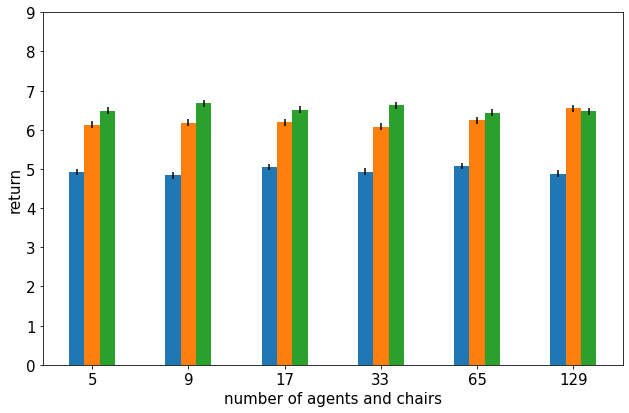

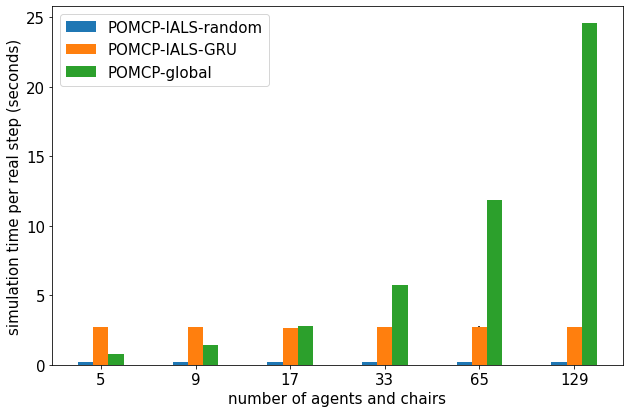

In [4]:
# GAC-num-agents: Figure 2(a) and 2(b)

xs = [5,9,17,33,65,129]
algos = ["inf_rand", "inf_gru_H8_D1000", "global"]
data = grab_data(xs, algos, lambda x: "results/GAC/{}agent/".format(x))

plt.rcParams.update({'font.size': 15})
labels = ["POMCP-IALS-random", "POMCP-IALS-GRU", "POMCP-global"]

plt.figure(figsize=(9,6))
plot_bar(
    results=data,
    algos=algos,
    labels=labels,
    xs=xs,
    metric="return",
    width=0.16
)
plt.xticks([i for i in range(len(xs))], xs)
plt.ylabel("return")
plt.ylim(0, 9.0)
plt.xlabel("number of agents and chairs")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plot_bar(
    results=data,
    algos=algos,
    labels=labels,
    xs=xs,
    metric="num_secs",
    width=0.16
)
plt.legend()
plt.xticks([i for i in range(len(xs))], xs)
plt.xlabel("number of agents and chairs")
plt.ylabel("simulation time per real step (seconds)")
plt.tight_layout()
plt.show()

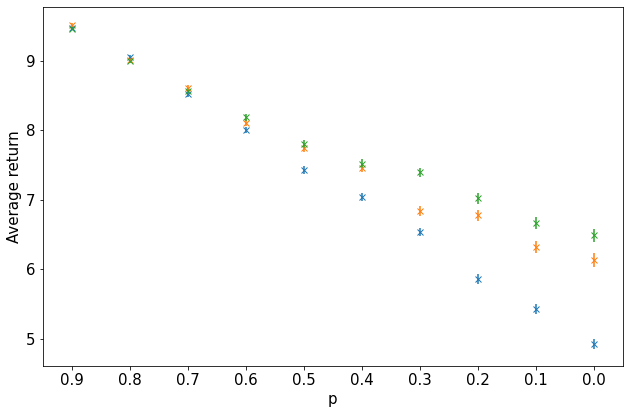

In [5]:
# GAC-coupling: Figure 3

xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
algos = ["inf_rand", "inf_gru_H8_D1000", "global"]
data = grab_data(xs, algos, lambda x: "results/GAC-coupling/p{}/".format("".join(str(x).split("."))))
data[0.0] = grab_data([5], algos, lambda x: "results/GAC/{}agent/".format(x))[5] # add data for p=0
xs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.rcParams.update({'font.size': 15})
labels = ["POMCP-IALS-random", "POMCP-IALS-GRU", "POMCP-global"]
plt.figure(figsize=(9,6))
plot_dots(
    results=data,
    algos=algos,
    labels=labels,
    xs=xs,
    metric="return"
)
plt.xlabel("p")
plt.xticks(xs)
plt.xlim(0.95, -0.05)
plt.ylabel("Average return")
plt.tight_layout()
plt.show()

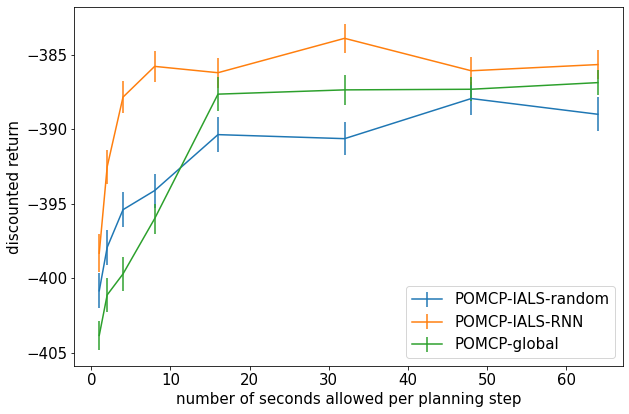

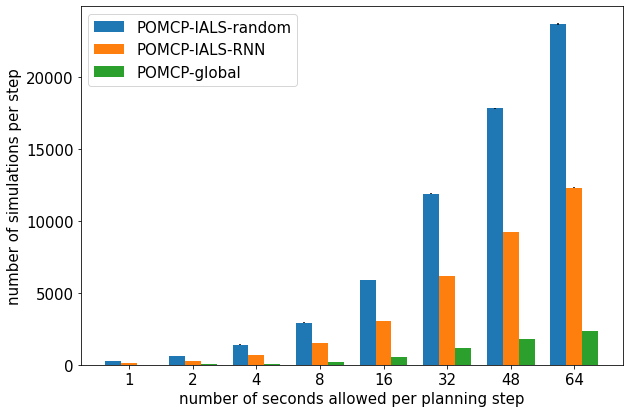

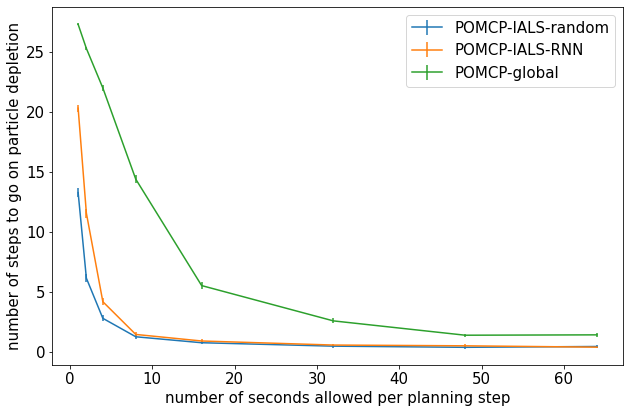

In [6]:
# GTC-real-time: Figure 4 (b), (c) and (d) 

secs = [1,2,4, 8, 16, 32, 48, 64]
algos = ["inf_rand", "inf_rnn_H2_D1000", "global"]
results = grab_data(secs, algos, lambda x: "results/GTC/{}sec/".format(x), horizon=30)

plt.rcParams.update({'font.size': 15})
labels = ["POMCP-IALS-random", "POMCP-IALS-RNN", "POMCP-global"]

plt.figure(figsize=(9,6))
plot_curve(
    results=results, 
    algos=algos, 
    xs=secs, 
    labels=labels, 
    metric="return")
plt.legend()
plt.ylabel("discounted return")
plt.xlabel("number of seconds allowed per planning step")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plot_bar(
    results=results,algos=algos,xs=secs,metric="num_sims",labels=labels,width=0.25
)
plt.xticks(list(range(len(secs))), secs)
plt.legend()
plt.ylabel("number of simulations per step")
plt.xlabel("number of seconds allowed per planning step")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
width = 0.3
plot_curve(
    results=results,algos=algos,xs=secs,metric="num_steps_to_go_on_particle_depletion",labels=labels
)
plt.legend()
plt.xlabel("number of seconds allowed per planning step")
plt.ylabel("number of steps to go on particle depletion")
plt.tight_layout()
plt.show()